In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, isnan, isnull
from pyspark.sql.types import IntegerType, StringType, FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [19]:
spark = SparkSession.builder.appName(
            "SentimentAnalysisBaseline"
        ).config(
            "spark.executor.memory", "16g"
        ).config(
            "spark.driver.memory", "32g"
        ).getOrCreate()

In [20]:
df = spark.read.csv("ggg_sg.csv", header=True, inferSchema=True, multiLine=True, escape='"')

24/09/27 00:55:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_24 in memory.
24/09/27 00:55:29 WARN MemoryStore: Not enough space to cache broadcast_24 in memory! (computed 384.0 B so far)
24/09/27 00:55:29 WARN BlockManager: Persisting block broadcast_24 to disk instead.
24/09/27 00:55:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_24 in memory.
24/09/27 00:55:29 WARN MemoryStore: Not enough space to cache broadcast_24 in memory! (computed 384.0 B so far)
24/09/27 00:55:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_25 in memory.
24/09/27 00:55:29 WARN MemoryStore: Not enough space to cache broadcast_25 in memory! (computed 384.0 B so far)
24/09/27 00:55:29 WARN BlockManager: Persisting block broadcast_25 to disk instead.
24/09/27 00:55:29 WARN MemoryStore: Failed to reserve initial memory threshold of 102

In [21]:
df.show()

+-------------------+--------------------+--------------------+--------------------+--------+-----------------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|           DateTime|                 URL|               Title|        SharingImage|LangCode|          DocTone|DomainCountryCode| Location|   Lat|  Lon|CountryCode|Adm1Code|Adm2Code|GeoType|      ContextualText|           the_geom|
+-------------------+--------------------+--------------------+--------------------+--------+-----------------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|2022-08-18 19:15:00|https://www.goal....|How to watch Manc...|https://assets.go...|     eng|0.764331210191083|               SP|Singapore|1.3667|103.8|         SN|      SN|    null|      1|nunez added to kl...|POINT(103.8 1.3667)|
|2021-03-09 01:30:00|https://www.labma...|Vetter Announces ...|https://w

In [22]:
df = df.filter(df.ContextualText.isNotNull())
df = df.filter(df.DocTone.isNotNull())

In [23]:
df = df.withColumn("DocTone", df["DocTone"].cast(FloatType()))

In [24]:
df.show(10)

+-------------------+--------------------+--------------------+--------------------+--------+-----------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|           DateTime|                 URL|               Title|        SharingImage|LangCode|    DocTone|DomainCountryCode| Location|   Lat|  Lon|CountryCode|Adm1Code|Adm2Code|GeoType|      ContextualText|           the_geom|
+-------------------+--------------------+--------------------+--------------------+--------+-----------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|2022-08-18 19:15:00|https://www.goal....|How to watch Manc...|https://assets.go...|     eng|  0.7643312|               SP|Singapore|1.3667|103.8|         SN|      SN|    null|      1|nunez added to kl...|POINT(103.8 1.3667)|
|2021-03-09 01:30:00|https://www.labma...|Vetter Announces ...|https://www.labma...|     eng|   

# Exploratory Data Analysis (DocTone)

In [25]:
from pyspark.sql.functions import col, min, max, avg, stddev, percentile_approx

# 计算基本统计信息
stats = df.select(
    min(col("DocTone")).alias("min_DocTone"),
    max(col("DocTone")).alias("max_DocTone"),
    avg(col("DocTone")).alias("avg_DocTone"),
    stddev(col("DocTone")).alias("stddev_DocTone")
).collect()[0]

print("DocTone Statistics:")
print(f"Min: {stats['min_DocTone']}")
print(f"Max: {stats['max_DocTone']}")
print(f"Average: {stats['avg_DocTone']}")
print(f"Standard Deviation: {stats['stddev_DocTone']}")


24/09/27 00:55:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_31 in memory.
24/09/27 00:55:55 WARN MemoryStore: Not enough space to cache broadcast_31 in memory! (computed 384.0 B so far)
24/09/27 00:55:55 WARN BlockManager: Persisting block broadcast_31 to disk instead.
24/09/27 00:55:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_32 in memory.
24/09/27 00:55:55 WARN MemoryStore: Not enough space to cache broadcast_32 in memory! (computed 384.0 B so far)
24/09/27 00:55:55 WARN BlockManager: Persisting block broadcast_32 to disk instead.
24/09/27 00:55:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_32 in memory.
24/09/27 00:55:55 WARN MemoryStore: Not enough space to cache broadcast_32 in memory! (computed 384.0 B so far)
24/09/27 00:55:55 WARN MemoryStore: Failed to reserve initial memory threshold of 102

DocTone Statistics:
Min: -28.947368621826172
Max: 34.78260803222656
Average: -0.03639324925228623
Standard Deviation: 3.1345220942204715


In [26]:
# 定义需要计算的分位数列表
quantiles = [0.0, 0.25, 0.5, 0.75, 1.0]

# 计算分位数
quantile_values = df.approxQuantile("DocTone", quantiles, relativeError=0.001)

# 输出分位数结果
for q, value in zip(quantiles, quantile_values):
    print(f"{int(q*100)}th percentile: {value}")


0th percentile: -28.947368621826172
25th percentile: -2.0202019214630127
50th percentile: 0.0
75th percentile: 1.9910084009170532
100th percentile: 34.78260803222656


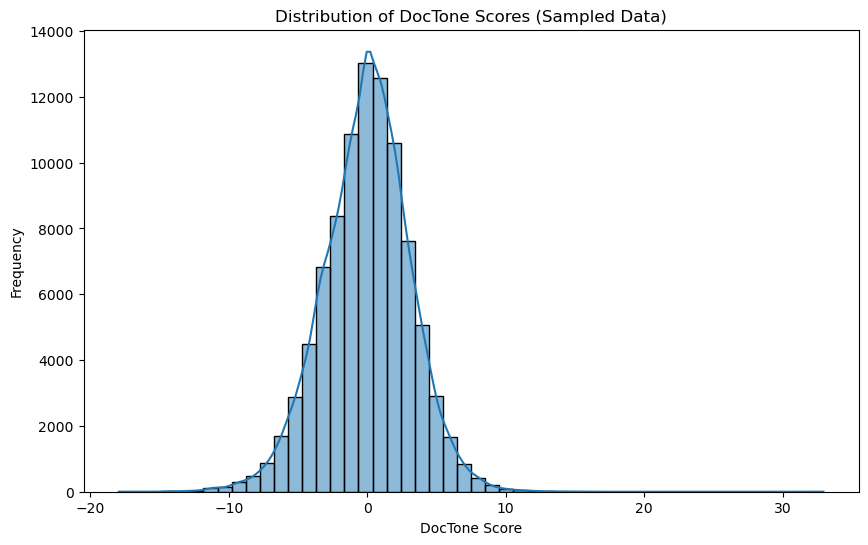

In [27]:
# 从数据集中抽样，例如抽取10万条记录
sample_df = df.select("DocTone").sample(False, 0.01, seed=42).limit(100000)

# 将抽样数据收集到驱动程序（注意数据量不要过大，以免内存不足）
doc_tone_values = sample_df.rdd.map(lambda row: row['DocTone']).collect()

# 使用matplotlib或seaborn绘制直方图
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(doc_tone_values, bins=50, kde=True)
plt.title('Distribution of DocTone Scores (Sampled Data)')
plt.xlabel('DocTone Score')
plt.ylabel('Frequency')
plt.show()


DocTone Statistics:

Min: -28.947368621826172

Max: 34.78260803222656

Average: -0.03639324925228623

Standard Deviation: 3.1345220942204715

0th percentile: -28.947368621826172

25th percentile: -2.0202019214630127

50th percentile: 0.0

75th percentile: 1.9910084009170532

100th percentile: 34.78260803222656

# Sentiment Analysis

In [28]:
# 创建情感标签：正面（1），中性（0），负面（-1）
def sentiment_label(score):
    if score > 1.9910:
        return 2  # 正面
    elif score < -2.0202:
        return 0  # 负面
    else:
        return 1  # 中性
    
sentiment_udf = udf(sentiment_label, IntegerType())

df = df.withColumn("label", sentiment_udf(col("DocTone")))

# 统计各类别的数量
label_counts = df.groupBy("label").count().orderBy("label")
label_counts.show()

+-----+-------+
|label|  count|
+-----+-------+
|    0|2297409|
|    1|4586529|
|    2|2301367|
+-----+-------+



In [29]:
# 分词
tokenizer = Tokenizer(inputCol="ContextualText", outputCol="words")

# 去除停用词
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# 特征提取（TF-IDF）
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# 建立机器学习管道
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

In [30]:
# 将数据集分为训练集和测试集
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

# 训练特征提取管道
pipelineModel = pipeline.fit(trainingData)
trainingData = pipelineModel.transform(trainingData)
testData = pipelineModel.transform(testData)

# 训练基线模型（逻辑回归）
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, family='multinomial')
lrModel = lr.fit(trainingData)


24/09/27 01:17:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/27 01:18:50 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 17.0 MiB so far)
24/09/27 01:18:50 WARN BlockManager: Persisting block rdd_164_0 to disk instead.
24/09/27 01:26:14 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:21 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:31 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:40 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:52 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:27:03 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:27:15 WARN MemoryStore: 

In [32]:
# 进行预测
predictions = lrModel.transform(testData)

In [33]:
# 评估模型
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % accuracy)

Test Accuracy = 0.729166 


In [35]:
# 查看精确率、召回率和F1分数
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7310097965622986
Recall: 0.7291663150352512
F1 Score: 0.728252326514687


# Random Forest Classifier

In [36]:
from pyspark.ml.classification import RandomForestClassifier

# 将数据集分为训练集和测试集
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

# 训练特征提取管道
pipelineModel = pipeline.fit(trainingData)
trainingData = pipelineModel.transform(trainingData)
testData = pipelineModel.transform(testData)

# 训练随机森林模型
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100, maxDepth=5, seed=42)
rfModel = rf.fit(trainingData)

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/Users/tedwu/anaconda3/envs/CS5344/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tedwu/anaconda3/envs/CS5344/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tedwu/anaconda3/envs/CS5344/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# 进行预测
predictions = rfModel.transform(testData)

In [ ]:
# 评估模型
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % accuracy)